# week 3 
저번주에 잘못한 것 수정하기 + 데이터셋 청원 데이터로 바꾸기

0) 데이터셋 변경 (v) 

1) forward, backward 는 k번째 토큰을 k 전의 토큰으로 예측 k 뒤의 토큰으로 예측함 (v)
→ rnn에서 hidden state forward, backward hidden 가져오면 됨. 어차피 time-step으로 예측함

2) padding : 0,  unk : 1 (v)

3) eos, sos는 추가하는게 맞겠다 <br>
lm에서 eos, sos를 추가하는게 맞나? -> 보류 

4) rnn을 for문 돌려서 넣을 필요 없이 바로 넣으면 된다. squeeze같은건 rnn 안에 넣자(src는 어차피 안씀) (v)

5) cnn에서 fc를 빼니 마니? (v)

6) gpu에서 나온 텐서를 쓰려면 스칼라로 만들어줘야함 
epoch_loss += loss.item() : 안하면 epoch_loss에 gpu 할당

7) max_len 긴게 너무 많아서 max 로 안구하고 직접 지정해주는게 나을듯 (v)

8) sent tokenize (v)

9) highway network 추가 (v)

# Data Download

In [1]:
device = 'cuda'

In [2]:
with open('../data/petitions_2019-01.txt', 'r') as f:
    corpus = f.readlines()

In [3]:
json_list = [eval(json.strip()) for json in corpus]

In [4]:
corpus = [json['content'] for json in json_list]

In [5]:
import pickle

In [6]:
with open('../data/petitions.p', 'wb') as f:
    pickle.dump(corpus, f)

# data preprocess

In [7]:
import re
import mecab
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import torchtext
import sys
sys.path.append('../source')
from txt_cleaner.clean.master import MasterCleaner
from txt_cleaner.utils import *
from torch8text.data import Vocab, Field

## sent_tokenize

In [8]:
from nltk.tokenize import sent_tokenize
sent_tokenize('안녕하세요? 반갑습니다. 오늘은 엘모를 구현보겠습니다?')

['안녕하세요?', '반갑습니다.', '오늘은 엘모를 구현보겠습니다?']

## field 1: mecab 사용 field

In [9]:
pos = mecab.MeCab()

def tokenize_pos(inp):
    if type(inp) == str:
        return pos.morphs(inp)
    if type(inp) == list:
        return [tokenize_pos(i) for i in inp]

In [10]:
tokenize_pos('안녕하세요'), tokenize_pos(['안녕하세요', '안녕?']), tokenize_pos([['안녕하세요'], ['안녕?']])

(['안녕', '하', '세요'],
 [['안녕', '하', '세요'], ['안녕', '?']],
 [[['안녕', '하', '세요']], [['안녕', '?']]])

### 수인님 cleaner 

In [11]:
config = json_reader('../source/txt_cleaner/cleaner_config.json')

size 1 dictionary is read from ../source/txt_cleaner/cleaner_config.json


In [12]:
config['minimum_space_count'] = 2
config

{'minimum_space_count': 2}

In [13]:
cleaner = MasterCleaner(config)
cleaner.cleaning('안녕하세요? 반갑습니다! 행복하세요~**')

'안녕하세요? 반갑습니다! 행복하세요'

In [14]:
tokenize_pos(['안녕하세요', '안녕'])

[['안녕', '하', '세요'], ['안녕']]

In [15]:
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

In [16]:
token_max_len = 40

In [17]:
mecab_field = Field(tokenize = tokenize_pos, 
                    preprocessing = lambda e: cleaner.cleaning(e),
                    init_token = False,
                    eos_token = False,
                    max_len = token_max_len
                )

In [18]:
flatten([[['dks','df']]])

['dks', 'df']

In [19]:
train = [sen
         for text in corpus 
         for sen in sent_tokenize(text)
         if cleaner.cleaning(sen)]
train[:5]

['국민과 소통하시고 자유롭고 행복한 나라를 만들기 위해 힘쓰고 계신 대통령께 존경과 찬사를 올립니다.',
 '기해년 새해 복 많이 받으십시오.',
 '저는 경북 울진군 북면 부구검성로 12번지에 살고 있는 북면발전협의회장 이희국이라고 합니다.',
 '저는 8기의 원전이 가동․건설되고 있는 이곳 북면에 태어나 68년째 거주하고 있는 원전지역 주민입니다.',
 '간절한 마음을 담아 대통령께 다음과 같이 호소 드립니다.']

In [20]:
mecab_field.build_vocab(train)
mecab_field.preprocess('안녕하세요? 룰루랄라 ㅇㅇㄹ')

['안녕', '하', '세요', '?', '룰루랄라']

In [21]:
train[:3]

['국민과 소통하시고 자유롭고 행복한 나라를 만들기 위해 힘쓰고 계신 대통령께 존경과 찬사를 올립니다.',
 '기해년 새해 복 많이 받으십시오.',
 '저는 경북 울진군 북면 부구검성로 12번지에 살고 있는 북면발전협의회장 이희국이라고 합니다.']

## field 2:  chr-level field

In [22]:
cleaner.cleaning('아')

''

In [23]:
cleaner = MasterCleaner({'minimum_space_count':0})
chr_field = Field(tokenize = list, 
                 preprocessing = lambda e: cleaner.cleaning(e) if len(e) > 1 else e,
                  init_token = False,
                  eos_token = False,
                )

In [24]:
chr_field.build_vocab(train)

In [25]:
token_chr = chr_field.preprocess('안녕하세요sd')
chr_field.process(token_chr)

[75, 524, 10, 63, 49, 348, 412]

# dataset, dataloader
## 헷갈리는 부분
bi-directional LSTM을 쓸건데 이게 다음 단어 예측하는 LM만 데이터를 구성하면 되나? 아니면 뒤에서부터 앞의 단어를 예측하는 LM도 구성해서 concat해야 하나? -> 일단 전자라고 생각하고 함

In [26]:
from collections import namedtuple  
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class ELMoDataset(Dataset):
    def __init__(self, src, mecab_field, chr_field, max_len):
        self.src = src
        self.mecab_field = mecab_field
        self.chr_field = chr_field
        self.named_tuple = namedtuple('data', ['src_chr', 'trg'])
        self.max_len = max_len
        
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.named_tuple(self.getitem(idx, is_char=True), self.getitem(idx)[1:]) 
    
    def getitem(self, idx, is_char=False):
        data = self.src[idx]
        tokenize_data = self.mecab_field.preprocess(data)[:self.max_len]
        if is_char:
            chrs = chr_field.preprocess(tokenize_data)
            pad_chrs = self.chr_field.pad_process(tokenize_data, max_len = self.max_len)
            return pad_chrs
        return torch.Tensor(self.mecab_field.vocab.stoi(tokenize_data)).long()

In [27]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

In [28]:
ds = ELMoDataset(train, mecab_field, chr_field, max_len = 3)

In [29]:
X  = [torch.tensor([[72,  0,  0,  0,  0]]), torch.tensor([[0, 0, 0, 0, 0]])]

In [30]:
torch.cat(X)

tensor([[72,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]])

In [31]:
chr_field.preprocess(['ek', 'edd'])

[[], []]

In [32]:
chr_max_len = 3

In [33]:
data = '안녕하세요 반갑습니ek edd'
token_data = mecab_field.preprocess(data)
print(token_data)
token_chr_data = chr_field.preprocess(token_data) #cleaning이 영어만 있으면 지워버림
print(token_chr_data)
process_chr = chr_field.pad_process(token_chr_data, max_len = chr_max_len)
print(process_chr)

['안녕', '하', '세요', '반갑', '습니', 'ek', 'edd']
[['안', '녕'], ['하'], ['세', '요'], ['반', '갑'], ['습', '니'], [], []]
tensor([[ 75, 524,   0],
        [ 10,   0,   0],
        [ 63,  49,   0],
        [169, 407,   0],
        [ 48,  11,   0]])


In [34]:
process_chr.shape

torch.Size([5, 3])

In [35]:
ds[1]

data(src_chr=tensor([[ 1,  0,  0],
        [97,  0,  0],
        [ 1,  0,  0]]), trg=tensor([  47, 1860]))

In [36]:
for _ in ds:
    print(_.src_chr)
    print(_.trg)
    break

tensor([[ 1,  0,  0],
        [64,  0,  0],
        [ 1,  0,  0]])
tensor([  35, 1711])


In [37]:
def pad_collate(batch):
    (src_chr, trg) = zip(*batch)
    named_tuple = namedtuple('data', ['src_chr', 'trg'])
    src_chr_pad = pad_sequence(src_chr, batch_first=True, padding_value=0)
    trg_pad = pad_sequence(trg, batch_first=True, padding_value=0)
    return named_tuple(src_chr_pad, trg_pad)

In [38]:
# def pack_pad_collate(batch):
#     (src, trg) = zip(*batch)
#     src_len = torch.Tensor([len(s) for s in src])
#     trg_len = torch.Tensor([len(t) for t in trg])
#     named_tuple = namedtuple('data', ['src', 'trg'])
#     src_pad = pad_sequence(src, batch_first=True, padding_value=0)
#     trg_pad = pad_sequence(trg, batch_first=True, padding_value=0)
#     src_pack = pack_padded_sequence(src_pad, lengths=src_len, batch_first=True, enforce_sorted=False)
#     trg_pack = pack_padded_sequence(trg_pad, lengths=trg_len, batch_first=True, enforce_sorted=False)
#     return named_tuple(src_pack, trg_pack)

In [39]:
BATCH_SIZE = 16

In [40]:
dl = DataLoader(ds, batch_size = BATCH_SIZE, collate_fn = pad_collate)
for _ in dl:
    print(_.src_chr.data)
    print(_.src_chr.data.shape)
    print(_.trg.data.shape)
    break

tensor([[[  1,   0,   0],
         [ 64,   0,   0],
         [  1,   0,   0]],

        [[  1,   0,   0],
         [ 97,   0,   0],
         [  1,   0,   0]],

        [[ 83,   0,   0],
         [  8,   0,   0],
         [  1,   0,   0]],

        [[ 83,   0,   0],
         [  8,   0,   0],
         [168,   0,   0]],

        [[  1,   0,   0],
         [ 18,   0,   0],
         [  1,   0,   0]],

        [[  1,   0,   0],
         [  1,   0,   0],
         [ 64,   0,   0]],

        [[  1,   0,   0],
         [  1,   0,   0],
         [  1,   0,   0]],

        [[  1,   0,   0],
         [ 18,   0,   0],
         [329,   0,   0]],

        [[  1,   0,   0],
         [  5,   0,   0],
         [  1,   0,   0]],

        [[ 33,   0,   0],
         [ 65,   0,   0],
         [  5,   0,   0]],

        [[542,   0,   0],
         [ 16,   0,   0],
         [  1,   0,   0]],

        [[  1,   0,   0],
         [216,   0,   0],
         [  1,   0,   0]],

        [[ 83,   0,   0],
         [ 27,

# CNN + highway

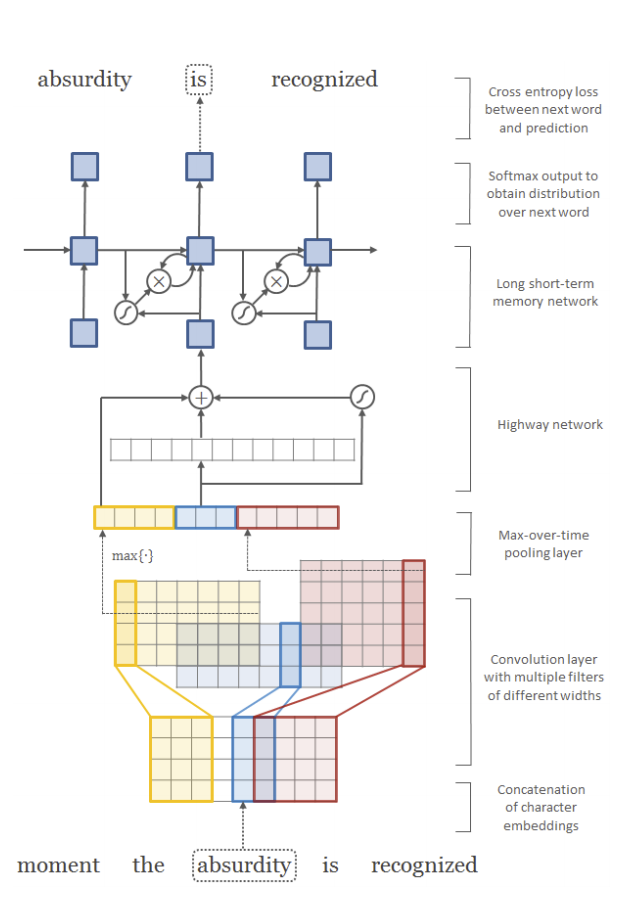

In [41]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim)) 
        
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))
        
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                        out_channels = n_filters, 
                        kernel_size = (filter_sizes[2], embedding_dim))

        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len, token len]
#         print(text.shape) # torch.Size([16, 64, 3])
        bs, max_seq_len, max_chr_len = text.shape
        
        embedded = self.embedding(text.reshape(-1, max_chr_len).unsqueeze(1))
#         print(embedded.shape) # batch_size * max_seq_len, 1, max_chr_len, embed_dim
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
#         print(conved_0.shape, conved_1.shape, conved_2.shape) 
#           torch.Size([1024, 10, 3]) torch.Size([1024, 10, 2]) torch.Size([1024, 10, 1]) 

#         print(conved_0.shape) # [1024, 10, 3]
        pooled_0 = torch.max(conved_0, dim = 1,).values
#         print(pooled_0.shape) # [1024, 3]
        pooled_1 = torch.max(conved_1, dim = 1).values
        pooled_2 = torch.max(conved_2, dim = 1).values
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = -1))
#         print(cat.shape) # 1024, 6
        cat = cat.view(bs, max_seq_len, -1) # 
#         print(cat.shape)
        return cat

In [42]:
VOCAB_SIZE = len(chr_field.vocab)
EMBEDDING_DIM = 1024
N_FILTERS = 10
FILTER_SIZES = (1, 2, 3)
PAD_IDX = chr_field.vocab.stoi_dict['<PAD>']
SPECIAL_TOKENS = chr_field.vocab.special_tokens
SPECIAL_TOKENS_INDEX = chr_field.vocab.special_tokens_idx
OUTPUT_DIM = 512
DROPOUT = 0.5

In [43]:
cnn = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [44]:
_.src_chr.data.shape # batch_size, max_seq_len(문장 내 토큰 개수), max_chr_len(토큰 내 chr개수)

torch.Size([16, 3, 3])

In [45]:
cnn_output = cnn(_.src_chr.data) # batch_size * max_seq_len, 1(channel 개수), max_chr_len 
cnn_output.shape # 3 (from conv 1) + 2 (from conv 2) + 1 (from conv 3)

torch.Size([16, 3, 6])

In [46]:
# https://github.com/kefirski/pytorch_Highway/blob/master/highway/highway.py
class Highway(nn.Module):
    def __init__(self, size, num_layers, f):

        super(Highway, self).__init__()

        self.num_layers = num_layers
        self.nonlinear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.linear = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.gate = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layers)])
        self.f = f

    def forward(self, x):
        """
            :param x: tensor with shape of [batch_size, size]
            :return: tensor with shape of [batch_size, size]
            applies σ(x) ⨀ (f(G(x))) + (1 - σ(x)) ⨀ (Q(x)) transformation | G and Q is affine transformation,
            f is non-linear transformation, σ(x) is affine transformation with sigmoid non-linearition
            and ⨀ is element-wise multiplication
            """

        for layer in range(self.num_layers):
            gate = torch.sigmoid(self.gate[layer](x))

            nonlinear = self.f(self.nonlinear[layer](x))
            linear = self.linear[layer](x)

            x = gate * nonlinear + (1 - gate) * linear

        return x

In [47]:
HIGHWAY_N_LAYERS = 1

In [48]:
highway = Highway(6, HIGHWAY_N_LAYERS, f=torch.nn.functional.relu)
highwayed_output = highway(cnn_output)
print(highwayed_output.shape)

torch.Size([16, 3, 6])


In [49]:
# https://github.com/GyuminJack/torchstudy/blob/main/05May/ELMo/src/models.py
class LSTM_LM(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout, bidirectional = bidirectional)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        input = input.permute(1, 0, 2)
        output, (hidden, cell) = self.lstm(input)  
        seq_len, bs, _ = output.size()
        output = output.reshape(seq_len, bs, -1, 2)
#         print(output.shape) # torch.Size([64, 16, 1024, 2])
        forward_hidden, backward_hidden = output[:,:,:,0], output[:,:,:,1]
        forward_prediction = self.fc_out(forward_hidden).permute(1, 0, 2)
        backward_prediction = self.fc_out(backward_hidden).permute(1, 0, 2)
        return forward_prediction, backward_prediction

In [50]:
OUTPUT_DIM

512

In [51]:
INPUT_DIM = OUTPUT_DIM
PREDICT_DIM = len(mecab_field.vocab)
HID_DIM = 1024
N_LAYERS = 2
DROPOUT = 0.5
BIDIRECTIONAL = True
TRG_PAD_IDX = mecab_field.vocab.stoi_dict['<PAD>']

In [52]:
rnn = LSTM_LM(6, PREDICT_DIM, HID_DIM, N_LAYERS, DROPOUT, BIDIRECTIONAL)

In [53]:
INPUT_DIM

512

In [54]:
forward_prediction, backward_prediction = rnn(highwayed_output)
forward_prediction.shape

torch.Size([16, 3, 50887])

`<sos>`토큰이랑 `<eos>` 토큰은 어떻게 CNN처리 해야하지?  -> 일단 빼는걸로 처리

In [76]:
class ELMo(nn.Module):
    def __init__(self, cnn, highway, rnn):
        super().__init__()
        self.cnn = cnn
        self.highway = highway
        self.rnn = rnn
        
    def forward(self, input):
        output = self.cnn(input)
        output = self.highway(output)
        forward_output, backward_output = self.rnn(output)
        return forward_output, backward_output

In [77]:
elmo = ELMo(cnn, highway, rnn)
elmo.to(device);

In [78]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(elmo.parameters(), lr=0.000005)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [79]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [80]:
elmo.apply(initialize_weights);

In [ ]:
log_epoch_loss = []
n_pass = 0
for epoch in range(10):
    print(f'Epoch {epoch}')
    optimizer.zero_grad()
    i = 0 
    epoch_loss = 0
    for src_chr, trg in dl:
        src_chr, trg = src_chr.to(device), trg.to(device)
        output = cnn(src_chr)
        output = highway(output)
        forward_output, backward_output = rnn(output)
        forward_loss = criterion(forward_output[:, :-1, :].reshape(-1, PREDICT_DIM), trg.reshape(-1))
        backward_loss = criterion(backward_output[:, :-1, :].reshape(-1, PREDICT_DIM), trg.reshape(-1))
        loss = forward_loss + backward_loss
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        i += 1
        if i % 100 == 0:
            print(float(loss.data), end='\t')
    log_epoch_loss += epoch_loss /

Epoch 0
21.585956573486328	21.547100067138672	21.58706283569336	21.5986270904541	21.52777671813965	21.514461517333984	21.526813507080078	21.556020736694336	21.61123275756836	21.534265518188477	21.564178466796875	21.574405670166016	21.511676788330078	21.56304359436035	21.530654907226562	21.5848331451416	21.482799530029297	21.56188201904297	21.497177124023438	21.546226501464844	21.54240608215332	21.50054931640625	21.508426666259766	21.497024536132812	21.451107025146484	21.524452209472656	21.542987823486328	21.51093101501465	21.507381439208984	21.555526733398438	21.429546356201172	21.517024993896484	21.439895629882812	21.536968231201172	21.47606658935547	21.48077392578125	21.501338958740234	21.44677734375	21.40990447998047	21.407697677612305	21.438020706176758	21.392501831054688	21.447490692138672	21.452312469482422	21.479618072509766	21.442699432373047	21.46833038330078	21.436893463134766	21.38202667236328	21.401763916015625	21.489110946655273	21.509305953979492	21.35110855102539	21.4808

In [69]:
import matplotlib.pyplot as plt

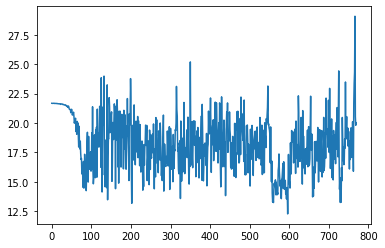

In [70]:
plt.plot(epoch_loss)